[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bartman_et_al_2021/demo_fig3.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bartman_et_al_2021/demo_fig3.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bartman_et_al_2021/demo_fig3.ipynb)

# TODO #1417

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from PySDM_examples.utils import ProgBarController
from open_atmos_jupyter_utils import TemporaryFile, show_plot
from PySDM.physics import si, convert_to
from PySDM_examples.utils.kinematic_2d import Simulation, Storage
from PySDM_examples.Arabas_et_al_2015 import Settings, SpinUp
from PySDM_examples.Bartman_et_al_2021.label import label
from PySDM.exporters import NetCDFExporter
import PySDM.products as PySDM_products
from matplotlib import pyplot, rcParams
from scipy.ndimage import uniform_filter1d
from scipy.io import netcdf_file
import numpy as np


In [3]:
ensemble_size = 3 if 'CI' not in os.environ else 2
runs = []
for _ in range(ensemble_size):
    runs.append({'file': TemporaryFile('.nc'), 'settings': {'coalescence_adaptive': True}})
for _ in range(ensemble_size):
    runs.append({'file': TemporaryFile('.nc'), 'settings': {'coalescence_adaptive': False, 'coalescence_substeps':  32 if 'CI' not in os.environ else 2}})
for _ in range(ensemble_size):
    runs.append({'file': TemporaryFile('.nc'), 'settings': {'coalescence_adaptive': False, 'coalescence_substeps':   1}})


In [4]:
radius_range = (.5*si.um, 25*si.um)
dt = 32 * si.s


In [5]:

for i, run in enumerate(runs):
    settings = Settings()

    products = (
        PySDM_products.DynamicWallTime('Collision', name='Coalescence_wall_time'),
        PySDM_products.SurfacePrecipitation(name='surf_precip', unit='mm/day'),
        PySDM_products.CollisionTimestepMin(name='dt_coal_min')
    )

    settings.n_sd_per_gridbox = 128 if 'CI' not in os.environ else 16
    settings.grid = (32, 32)
    settings.dt = dt
    settings.condensation_dt_cond_range = (.25*si.s, settings.dt)
    
    settings.mode_1.norm_factor *= 3
    settings.mode_2.norm_factor *= 3
    settings.spectrum_per_mass_of_dry_air.norm_factor *= 3
    settings.simulation_time = settings.spin_up_time * (2 if 'CI' not in os.environ else 1.5)
    settings.output_interval = settings.dt
    settings.condensation_adaptive = True
    settings.condensation_rtol_x = 1e-6
    settings.condensation_rtol_thd = 2e-5/7/7
    settings.condensation_schedule = 'dynamic'
    settings.kappa = .8
    
    for key, value in run['settings'].items():        
        assert hasattr(settings, key)
        setattr(settings, key, value)
    
    storage = Storage()
    simulation = Simulation(settings, storage, SpinUp=SpinUp)
    simulation.reinit(products)

    simulation.run(ProgBarController(f"run {i+1}/{len(runs)}"))
    exporter = NetCDFExporter(storage, settings, simulation, run['file'].absolute_path)
    exporter.run(ProgBarController('netCDF'))

FloatProgress(value=0.0, description='run 1/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 2/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 3/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 4/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 5/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 6/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 7/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 8/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 9/9', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

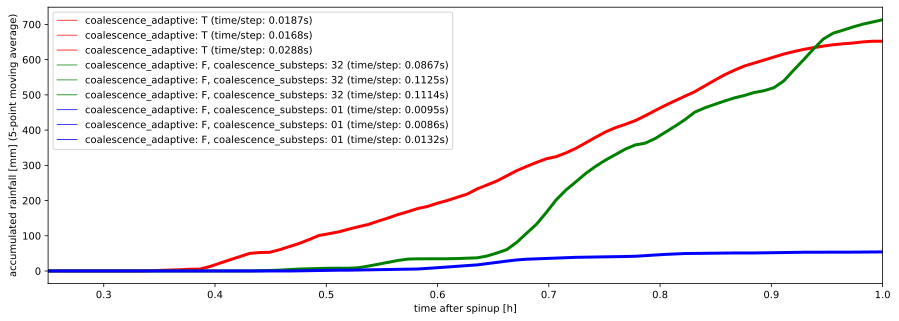

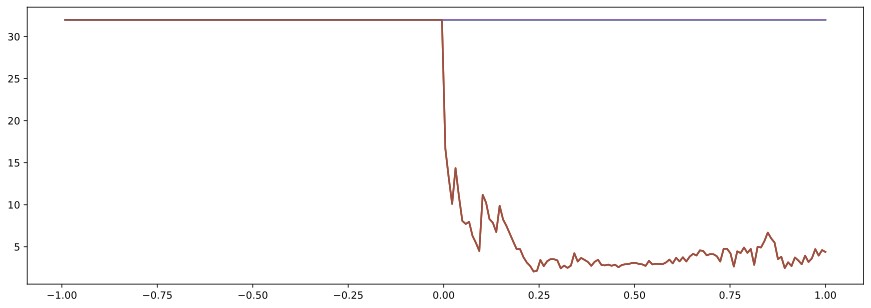

In [6]:
rcParams["figure.figsize"] = (15, 5)

timeaxis = lambda t: t / 3600 - 1

dt_day = dt
convert_to(dt_day, si.day)

window=5
colors=['red', 'green', 'blue']

for i, run in enumerate(runs):
    nc = netcdf_file(run['file'].absolute_path, mode='r', mmap=False)
    wall_time = np.mean(nc.variables['Coalescence_wall_time'][:-10])  # TODO #449
    wall_time = int(10000 * wall_time) / 10000
    filtered_cumsum = uniform_filter1d(dt_day * np.cumsum(nc.variables['surf_precip'][:]), size=window)
    pyplot.plot(
        timeaxis(nc.variables['T'][:]),
        filtered_cumsum,
        label=f"{label(run['settings'])} (time/step: {wall_time:.4f}s)",
        color=colors[i//ensemble_size],
        lw=.75
    )
    if i % ensemble_size == 0:
        mean = np.copy(filtered_cumsum)
    else:
        mean += filtered_cumsum
    if (i+1) % ensemble_size == 0:
        pyplot.plot(
            timeaxis(nc.variables['T'][:]),
            mean / ensemble_size,
            lw=3,
            color=colors[i // ensemble_size]
        )
pyplot.xlim(timeaxis(1.25 * settings.spin_up_time), timeaxis(nc.variables['T'][-1]))
pyplot.legend()
pyplot.ylabel('accumulated rainfall [mm] ' + f'({window}-point moving average)')
pyplot.xlabel('time after spinup [h]')
show_plot()


for i, run in enumerate(runs):
    if not run['settings']['coalescence_adaptive']:
        continue
    nc = netcdf_file(run['file'].absolute_path, mode='r', mmap=False)
    data = nc.variables['dt_coal_min'][:]
    pyplot.plot(timeaxis(nc.variables['T'][:]), np.amax(np.amax(data, axis=-1), axis=-1))
    pyplot.plot(timeaxis(nc.variables['T'][:]), np.amin(np.amin(data, axis=-1), axis=-1))
show_plot()

In [7]:
# TODO #449: initialisation
# TODO #449: rng_reuse
# TODO #449: seed, spread
# TODO #449: sd_num ?
# TODO #449: plot deficit
# TODO #449: dt histogram